<a href="https://colab.research.google.com/github/cfong32/data6100-proj2/blob/master/data6100_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Executive Summary

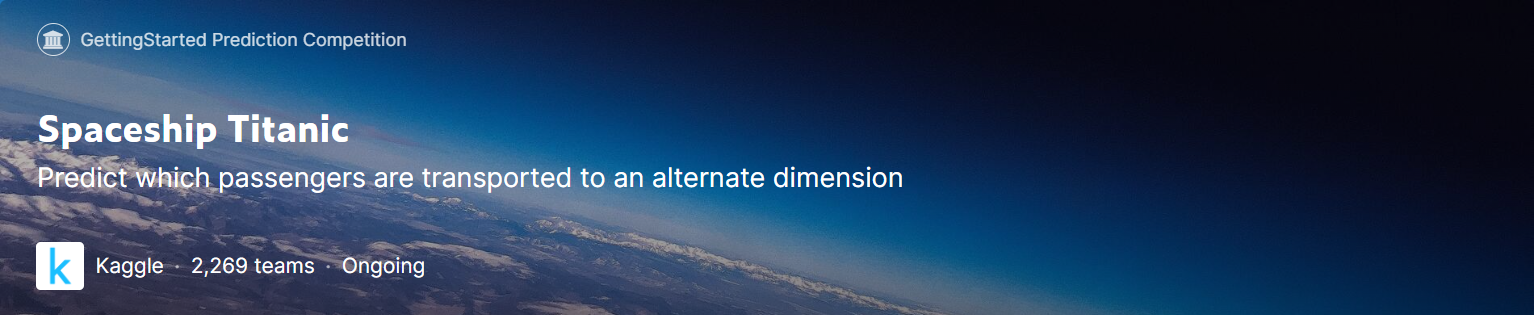

- In this project, we’ve joined the Kaggle competition Spaceship Titanic trying to predict whether each of the passengers on it was accidentally transported to another dimension.  We applied and compared how two different methods --- logistic regression and Naïve Bayes discriminant analysis --- perform on this problem.

- By changing all the numerical variables into new Bernoulli categorial variables, we get a more efficient set of variables for both methods.  Finally, our fitted models achieved comparable performances.   Our logistic regression model scored 0.74421 in accuracy, while the Bernouli Naïve Bayes model scored 0.74584.

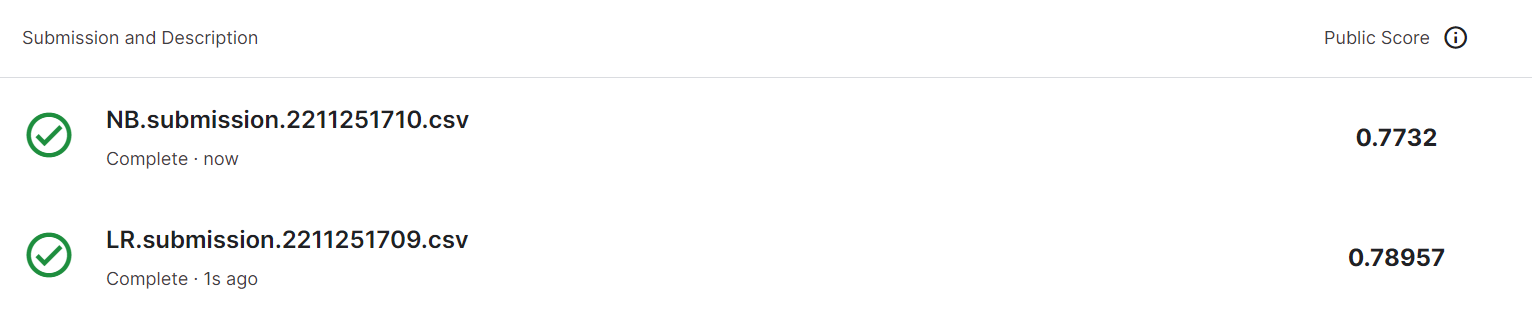

# II. Ethics Discussion

Because this dataset is completely fictitious, and the significance of creating this data is mainly for education, analysis, and establishment of the model. There will not be too many practical ethical issues. But if we imagine ourselves living in the same context for real, some ethical issues would definitely draw more of our attention.

#### 1. Privacy
This dataset is exposing many of the passengers' personal details, such as their names, homes, destinations and expenses, to the public. Such release of personal information should require passengers' consent. Without their consent (of using their data for this task), the spaceship company should not have released this dataset to us.

#### 2. Purpose and limit on data use
Let us assume that all passengers had agreed that their personal information could be used for analysis in case of accident. We should still limit ourselves to using this dataset ONLY for analysis purposes. Preferably, after the analysis, we should totally remove this dataset from our hard disks.

#### 3. Prediction biases
While filling missing data, we may unintentionally impose biases on the prediction results. Suppose we are going to fill all missing "age" by the median. Doing so would alter the actual age distribution. As a result, regardless of what missing filling strategy we eventually choose, the model (our algorithm) could still misinterpret responses or characteristics of certain age group.

#### 4. What if not all passengers were protected equally
Ideally, all passengers should be protected equally. Their survival should not be judged by their VIP status or money that they spent on the ship. However, if the data really shows that statistically this is not the case. What if certain groups of passengers were “more protected” than some others. Should we have the responsibility to report such partiality to the public? Yes, maybe we should.

# III. Exploratory Data Analysis

In [ ]:
###
# Upload and unzip data ("spaceship-titanic.zip")
###

from google.colab import files
from zipfile import ZipFile

uploaded = files.upload()
with ZipFile('spaceship-titanic.zip') as z:
    z.extractall()

Saving spaceship-titanic.zip to spaceship-titanic (5).zip


In [ ]:
###
# Import packages
###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.min_rows', 4)

In [ ]:
###
# Read train dataset and test dataset and merge them with labeled as 'train' and 'test'
###

def read_whole_dataset():
    df_train = pd.read_csv('train.csv')
    df_test  = pd.read_csv('test.csv')
    df = pd.concat([df_train.assign(dataset='train'),
                    df_test.assign(dataset='test')])
    return df
    
df = read_whole_dataset()
display(df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,dataset
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,train
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,test
4276,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,test


## Numerical Features

Basic statistics:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



Histograms:


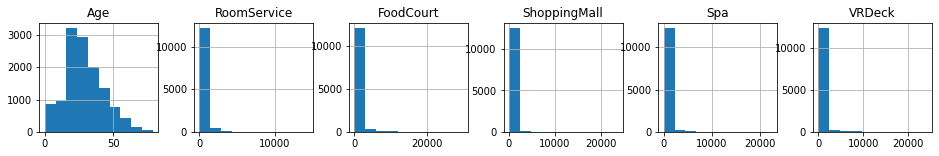

In [ ]:
###
# Analyze characteristics of the numercial features
###

cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

## Show basic stats
print('Basic statistics:')
display(df[cols].describe())

## Plot histograms
print()
print('Histograms:')
fig, axes = plt.subplots(1,6, figsize=(16,2))
for i, col in enumerate(cols):
    df[[col]].hist(
        ax=axes.flat[i],
    )
plt.show()

### Age

**Observations and actions**
- We found that `'Age'` below certain threshold (e.g. 18) is more correlated to the output variable `'Transported'`.

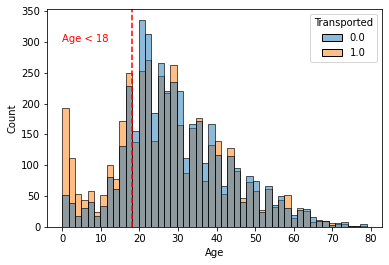

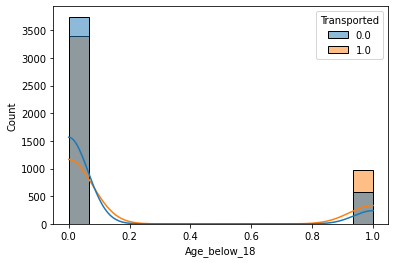

In [132]:
###
# Plot histogram of Age
###

# Histogram
sns.histplot(
    data=df[df.dataset=='train'],
    x='Age',
    hue='Transported',
)
plt.axvline(18, ls='--', color='r')
plt.text(0, 300, 'Age < 18', color='r')
plt.show()

# Plot 'Age_below_18' vs 'Transported'
df['Age_below_18']  = (df['Age'] < 18).astype(float)
sns.histplot(
    data=df[df.dataset=='train'],
    x='Age_below_18',
    hue='Transported',
    kde=True,
)
plt.show()

### RoomService, FoodCourt, ShoppingMall, Spa and VRDeck

**Observations and actions**
- Distributions of `['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']` are heavily right-skewed.
    - Converting them to *Bernoulli variables* could be more effective for classification models.
    - In fact, more than 60% of their values are just "0".
        - So, we created `'zero_XXX'` to indicate whether the person spent money on those services or not.
    - "High expenses" are found to be correlated to the NOT being `'Transported'`.
        - So, we created `'top10p_XXX'` to indicate whether the person is among the top 10% most spenting customers.
        - Later we will also use `'top20p_XXX'` and `'top5p_XXX'` for model fitting.

Number of zeros found in each column:
RoomService     0.640170
FoodCourt       0.628065
ShoppingMall    0.642328
Spa             0.611796
VRDeck          0.636237
dtype: float64

Zero expense vs Transported


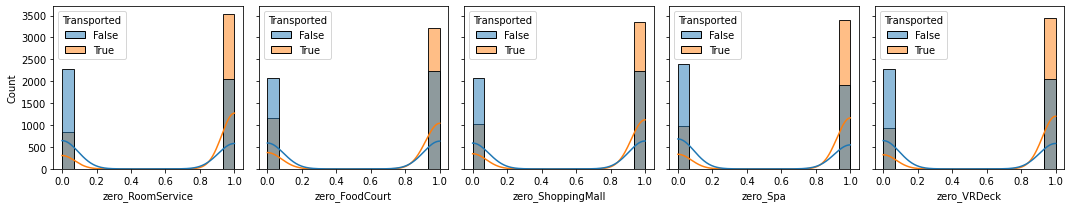


Top-10-percentile expense vs Transported


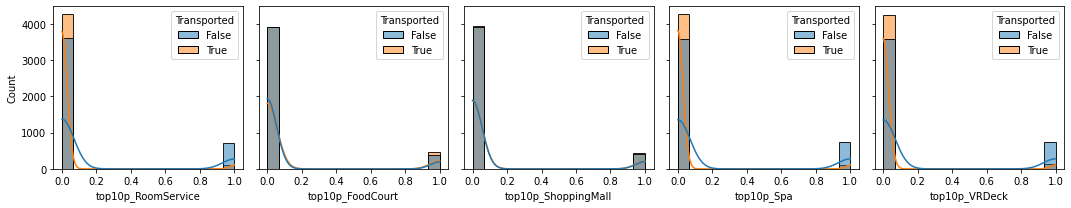

In [ ]:
###
# Look into those columns of expenses
# See how "zero expense" and "high expense" relate to 'Transported'
###

cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

## Count how many of zeros are there
print('Number of zeros found in each column:')
print((df[cols] == 0).sum() / len(df))

# Add columns 'zero_XXX', 'top10p_XXX'
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in cols:
    df[f'zero_{col}']   = (df[col] == 0).astype(float)
    df[f'top10p_{col}'] = (df[col] >= df[col].quantile(.9)).astype(float)

# Plot 'zero_XXX' vs 'Transported'
print()
print('Zero expense vs Transported')

cols = ['zero_RoomService', 'zero_FoodCourt', 'zero_ShoppingMall', 'zero_Spa', 'zero_VRDeck']
fig, axes = plt.subplots(1,5, figsize=(15,3), sharey=True)

for col, ax in zip(cols, axes.flat):
    sns.histplot(
        data=df[df.dataset=='train'],
        x=col,
        hue='Transported',
        kde=True,
        ax=ax
    )
plt.tight_layout()
plt.show()

# Plot 'top10p_XXX' vs 'Transported'
print()
print('Top-10-percentile expense vs Transported')

cols = ['top10p_RoomService', 'top10p_FoodCourt', 'top10p_ShoppingMall', 'top10p_Spa', 'top10p_VRDeck']
fig, axes = plt.subplots(1,5, figsize=(15,3), sharey=True)

for col, ax in zip(cols, axes.flat):
    sns.histplot(
        data=df[df.dataset=='train'],
        x=col,
        hue='Transported',
        kde=True,
        ax=ax
    )
plt.tight_layout()
plt.show()

## Categorical Features

**Observations and actions**
- For the categorical features, there is one special called `'Cabin'`. We noticed that this variable actually provides information about the *deck*, *number*, and *side* of where the passengers were staying.
    - We though that only *deck* and *side* can be easily transformed into dummy variables which are correlated to `'Transported'`.
    - So, in the coming **Data Preprocessing** step, we will
        - Create two new variables called `'Cabin_deck'` and `'Cabin_side'`.
        - Change **all categorical variables into dummy variables** for further model fitting.

In [ ]:
###
# Extract 'Cabin_deck' and 'Cabin_side'
###

df['Cabin_deck'] = df.Cabin.str.split('/').map(lambda x: x[0] if isinstance(x, list) else np.NaN)
df['Cabin_side'] = df.Cabin.str.split('/').map(lambda x: x[2] if isinstance(x, list) else np.NaN)

display(df[['Cabin', 'Cabin_deck', 'Cabin_side']])

,Cabin,Cabin_deck,Cabin_side
0,B/0/P,B,P
1,F/0/S,F,S
...,...,...,...
4275,D/297/P,D,P
4276,G/1498/S,G,S


# IV. Data Preprocessing

In [ ]:
###
# Read the whole dataset (train + test) again
###

df = read_whole_dataset()
display(df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,dataset
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,train
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,test
4276,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,test


In [ ]:
###
# Data preprocessing
###

cols_expense = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cols_to_fillna_with_median = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cols_to_get_dummies = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']
cols_to_float = ['Transported']

# Add the 'Age_below_18' column
df['Age_below_18']  = (df['Age'] < 18).astype(float)

# Add extra columns indicating if the values are
# 1) zero, 2) among the top 20%, 3) among the top 10%, or 4) among the top 5%
for col in cols_expense:
    df[f'zero_{col}'] = (df[col] == 0).astype(float)
    df[f'top20p_{col}'] = (df[col] >= df[col].quantile(.8)).astype(float)
    df[f'top10p_{col}'] = (df[col] >= df[col].quantile(.9)).astype(float)
    df[f'top5p_{col}']  = (df[col] >= df[col].quantile(.95)).astype(float)

# Make columns for "Cabin_deck" and "Cabin_side"
df['Cabin_deck'] = df.Cabin.str.split('/').map(lambda x: x[0] if isinstance(x, list) else np.NaN)
df['Cabin_side'] = df.Cabin.str.split('/').map(lambda x: x[2] if isinstance(x, list) else np.NaN)

# Fillna with median values
for col in cols_to_fillna_with_median:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns into dummy variables
df = pd.concat([df.drop(columns=cols_to_get_dummies),
                pd.get_dummies(df[cols_to_get_dummies])],
               axis=1)

# Convert some columns into float
df[cols_to_float] = df[cols_to_float].astype(float)

# print the preprocessed dataframe
display(df)

,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,...,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S
0,0001_01,B/0/P,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,...,0,1,0,0,0,0,0,0,1,0
1,0002_01,F/0/S,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,9273_01,D/297/P,27.0,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,...,0,0,0,1,0,0,0,0,1,0
4276,9277_01,G/1498/S,43.0,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
###
# Choose input features
# Prepare X and y for logistic regression model
###

## Prepare training and test data for different model
def pre_data(dataframe, features_lst):
  # Output target, y
  col_y = 'Transported'

  # Make sure there is no NA
  train_set = df.dataset=='train'                     # select only the training set
  assert dataframe[train_set][features_lst].notna().all().all()
  assert dataframe[train_set][col_y].notna().all().all()

  # Standardize X and y
  sr_mean_X, sr_std_X = dataframe[features_lst].mean(), dataframe[features_lst].std()
  X_train = ((dataframe[train_set][features_lst] - sr_mean_X) / sr_std_X).values
  y_train = dataframe[train_set][col_y].values

  return X_train, y_train, sr_mean_X, sr_std_X

# Input features, X
cols_X_all = [
    ## Set 1 (18 variables)
    'Cabin_deck_A', 'Cabin_deck_B', 'Cabin_deck_C', 'Cabin_deck_D',
    'Cabin_deck_E', 'Cabin_deck_F', 'Cabin_deck_G', 'Cabin_deck_T',
    'Cabin_side_P',
    'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
    'CryoSleep_True',
    'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
    'VIP_False', 'VIP_True',
    # exclude 'Cabin_side_S', 'CryoSleep_False',
    # because they are correlated too much (>0.8) to other features

    ## Set 2 (21 variables)
    'Age_below_18',
    'zero_RoomService',   'zero_FoodCourt',   'zero_ShoppingMall',   'zero_Spa',   'zero_VRDeck',
    'top20p_RoomService', 'top20p_FoodCourt', 'top20p_ShoppingMall', 'top20p_Spa', 'top20p_VRDeck',
    'top10p_RoomService', 'top10p_FoodCourt', 'top10p_ShoppingMall', 'top10p_Spa', 'top10p_VRDeck',
    'top5p_RoomService',  'top5p_FoodCourt',  'top5p_ShoppingMall',  'top5p_Spa',  'top5p_VRDeck',
]

## Prepare the training data set for the logistic regression
(X_train_LR, y_train_LR, mean_X_LR, std_X_LR) = pre_data(df, cols_X_all)

X_train_LR.shape, y_train_LR.shape

((8693, 39), (8693,))

In [ ]:
# Find the high correlated variables from the dataset
corr_matrix = df.corr().abs()

## Get the upper triangle elements from the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 

# Find the variable names whcih has correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Choose input features
# Prepare X and y for Navie Bayes Model

# Input features, X
cols_X_NB = list(set(cols_X_LR) - set(to_drop) - {'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'})

## Prepare the training data set for the logistic regression
(X_train_NB, y_train_NB, mean_X_NB, std_X_NB) = pre_data(df, cols_X_NB)

X_train_NB.shape, y_train_NB.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


((8693, 39), (8693,))

# V. Logistic Regression

In [ ]:
###
# Logistic Regression
###

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

LRmodel = LogisticRegression(random_state=0, penalty='l1', solver = 'saga', C = 0.01)
LRscores = cross_val_score(LRmodel, X_train_LR, y_train_LR, cv=10)

print('5-fold cross-validation accuracies:', LRscores)
print('Mean cross-validation accuracies:', np.mean(LRscores))

5-fold cross-validation accuracies: [0.77931034 0.76436782 0.78505747 0.79746835 0.79056387 0.79976985
 0.78020713 0.78481013 0.82048331 0.77330265]
Mean cross-validation accuracies: 0.7875340925624644


# VI. Linear Discriminant Analysis

## Our approach

We perform Linear Discriminant Analysis through fitting our data to **Bernoulli Naive Bayes (NB) models**.  Here is our approach to find the optimal feature set:
1. Each Bernoulli input variable is fitted to the model to obtain its **marginal accurarcy -- accurarcy using one feature alone**.
2. Features are sorted by their marginal accurarcies.
3. Starting from the feature with the best accuracy, features are added one-by-one into the training process.  Eventually, we would like to see which **top-K** features are able to produce the best NB models.

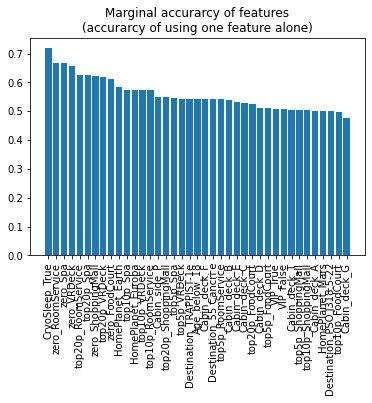

In [124]:
###
# Using Bernoulli Naive Bayes,
# Find which features can give the best accuracy
###

from sklearn.naive_bayes import BernoulliNB

NBmodel = BernoulliNB()

# Find marginal accuracies of individual features
scores = []
for i, col in enumerate(cols_X_all):
    cols_X_NB = [col]
    (X_train_NB, y_train_NB, mean_X_NB, std_X_NB) = pre_data(df, cols_X_NB)
    cv_score = cross_val_score(NBmodel, X_train_NB, y_train_NB, cv=10).mean()
    scores.append(cv_score)

# Sort features by their score (marginal accuracy)
idx = np.argsort(scores)
scores_ordered    = [scores[i] for i in reversed(idx)]
cols_X_NB_ordered = [cols_X_all[i] for i in reversed(idx)]

# Plot scores of all features
plt.bar(cols_X_NB_ordered, scores_ordered)
plt.title('Marginal accurarcy of features\n(accurarcy of using one feature alone)')
plt.xticks(rotation=90)
plt.show()

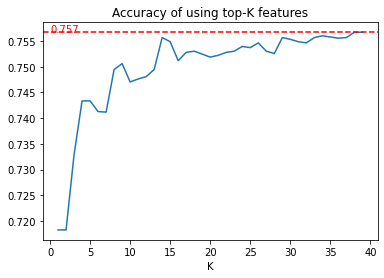

In [134]:
###
# Search for optimal K,
# such that the NB model with the top-K features give the best performance
###

NBmodel = BernoulliNB()
scores = []

# Try different number of top-K features
for K in range(1, len(cols_X_NB_ordered)+1):
    cols_X_NB = cols_X_NB_ordered[:K]
    (X_train_NB, y_train_NB, mean_X_NB, std_X_NB) = pre_data(df, cols_X_NB)
    cv_scores = cross_val_score(NBmodel, X_train_NB, y_train_NB, cv=10)
    scores.append(np.mean(cv_scores))

# Plot result
plt.plot(np.arange(len(scores))+1, scores)
plt.axhline(max(scores), ls='--', color='r')
plt.text(0, max(scores), max(scores).round(3), color='r')
plt.title('Accuracy of using top-K features')
plt.xlabel('K')
plt.show()

## Our findings

*Surprisingly, we found that **including all** Bernoulli features gives the best performance.*

# VII. Interpretations and Comparsions

## Interpretations of the logistic regression model

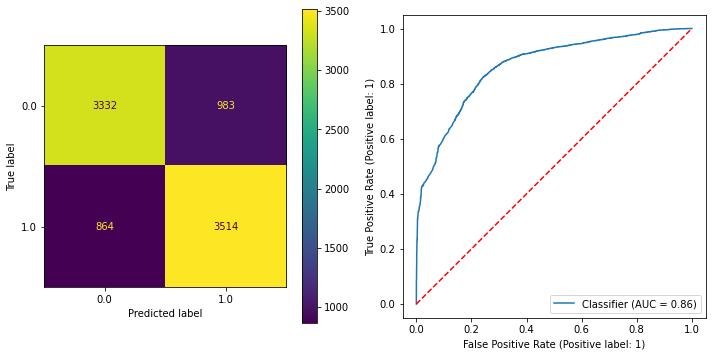

Precision 0.7814098287747387
Recall: 0.8026496116948378


In [ ]:
###
# Evaluate the logistic regression model
###

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Predict in a cross-validation setting
y_proba_LR = cross_val_predict(LRmodel, X_train_LR, y_train_LR, cv=10, method='predict_proba')[:,1]
y_pred_LR  = y_proba_LR > 0.5

# Show confusion matrix and ROC curve
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ConfusionMatrixDisplay.from_predictions(y_train_LR, y_pred_LR, ax=ax1)
RocCurveDisplay.from_predictions(y_train_LR, y_proba_LR, ax=ax2)
ax2.plot([0,1], [0,1], 'r--')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

# Show precision ane recall
print('Precision', precision_score(y_train_LR, y_pred_LR))
print('Recall:', recall_score(y_train_LR, y_pred_LR))

## Interpretations of the Bernoulli naive bayes model

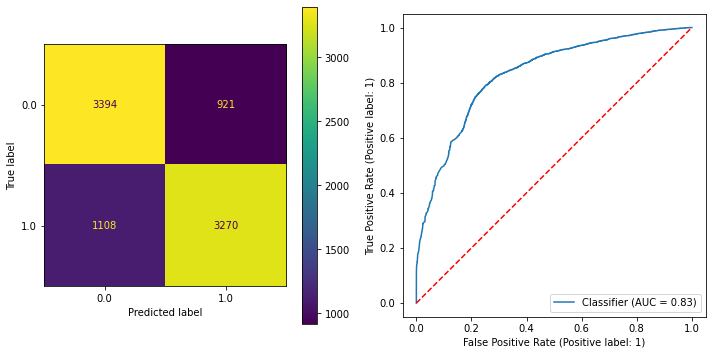

Precision 0.7802433786685755
Recall: 0.7469164001827319


In [ ]:
###
# Evaluate the NB model
###

# Predict in a cross-validation setting
y_proba_NB = cross_val_predict(NBmodel, X_train_NB, y_train_NB, cv=10, method='predict_proba')[:,1]
y_pred_NB  = y_proba_NB > 0.5

# Show confusion matrix and ROC curve
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ConfusionMatrixDisplay.from_predictions(y_train_NB, y_pred_NB, ax=ax1)
RocCurveDisplay.from_predictions(y_train_NB, y_proba_NB, ax=ax2)
ax2.plot([0,1], [0,1], 'r--')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

# Show precision ane recall
print('Precision', precision_score(y_train_NB, y_pred_NB))
print('Recall:', recall_score(y_train_NB, y_pred_NB))

## Comparison of the predicited probabilities

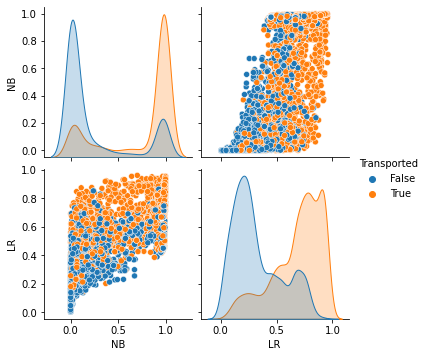

In [ ]:
###
# Pair plot of comparing the predicted probability values
###

sns.pairplot(
    data=pd.DataFrame({'NB': np.array(y_proba_NB),
                       'LR': np.array(y_proba_LR),
                       'Transported': y_train_LR.astype(bool)}),
    hue='Transported',
)
plt.show()

# VIII. Output for Kaggle Submission

In [ ]:
###
# Save submission csv file
###

import pytz
from datetime import datetime, timezone

# make submission csv
def make_submission_csv(y_hat, prefix):
    df_submission = pd.DataFrame({
        'PassengerId': df[test_set].PassengerId,
        'Transported': y_hat.astype(bool)
    })

    timestr = datetime.now(pytz.timezone('Canada/Eastern')).strftime("%y%m%d%H%M")
    save_path = f'{prefix}.submission.{timestr}.csv'
    df_submission.to_csv(save_path, index=False)
    print('saved to', save_path)

In [ ]:
###
# Train a new logistic regression model with all training data
# to predict on test data
###

# Training
model = LogisticRegression(random_state=0)
model.fit(X_train_LR, y_train_LR)

# Predict on test set
test_set = df.dataset == 'test'
X_test = ((df[test_set][cols_X_LR] - mean_X_LR) / std_X_LR).values
y_hat = model.predict(X_test)
print(X_test.shape, y_hat.shape)

# save as csv
make_submission_csv(y_hat, 'LR')

(4277, 39) (4277,)
saved to LR.submission.2211251723.csv


In [ ]:
###
# Train a new naive bayes model with all training data
# to predict on test data
###

# Training
NBmodel = BernoulliNB()
NBmodel.fit(X_train_NB, y_train_NB)

# Predict on test set
test_set = df.dataset == 'test'
X_test = ((df[test_set][cols_X_NB] - mean_X_NB) / std_X_NB).values
y_hat = NBmodel.predict(X_test)
print(X_test.shape, y_hat.shape)

# save as csv
make_submission_csv(y_hat, 'NB')

(4277, 38) (4277,)
saved to NB.submission.2211251723.csv
